# COMP 2002 Intro to AI
## Assignment

This assignment contributes 70% of the overall module mark for COMP2002 and is an individual
assignment. You must submit the deliverables to the DLE by the specified submission dates.

The coursework has two parts – one is a machine learning exercise and the second is about
evolutionary computation. You must complete and submit both parts. Each part is worth 50% of
the coursework mark.

# Part 1 - ML

You have been provided with datasets relating to the energy efficiency of buildings. Your task is to
train regression models that predict two indicators of energy efficiency based on 8 numerical inputs.

## Task 1.1 - Data preparation 

The first phase of the work requires you to load the data you have been provided with into your Python
program. Before the data can be used to train and test your models you must first prepare it – this
means that the inputs must be normalized. There is no missing data in the dataset.

(10% of total mark)

## Task 1.2 - Regression 

Having prepared the data you must now build a regression tool that can predict new points. Use the
following regression implementations within the scikit-learn package to construct predictors for the
dataset:

- Random Forest (sklearn.ensemble.RandomForestRegressor)
- Neural Network (sklearn.neural_network.MLPRegressor)
- Support Vector Machine (sklearn.svm.SVR)

You must demonstrate that each regressor is capable of providing a prediction for a given input.

(20% of total mark)

## Task 1.3 – Assessment of regression 

The regression models you have used in the previous task must be assessed. To do this you are
required to assess the mean square error rate for each model. You may use the MSE implementation
available in scikit-learn to do this. It is not sufficient to report a single MSE rate. You must use cross
validation to report training and testing results and report these values using a boxplot.

(20% of total mark)

## Import Required Libraries

In [1]:
import pandas as pandas
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

## Data Preparation

### Load with Pandas

In [2]:
data = pandas.read_csv("data.csv")

print(data)

       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


### Extract the Data

In [124]:
inputs = data.values[:,:8].astype(float)
targets = data.values[:,8:].astype(float)

targets_y1 = targets[:,:1].astype(float)
targets_y2 = targets[:,1:].astype(float)

### Split Data into Training and Testing Sets

We need to split the data into a training and testing set, we will have a test set that contains 25% of the data and use the remaining 75% for training.

In [4]:
trainInputs, testInputs, trainTargets, testTargets = train_test_split(inputs, 
                                                                          targets, 
                                                                          test_size=0.25)

targets_y1 = targets[:,8:9]
targets_y2 = targets[:,9:]

### Shuffel the Array

They look unordered, but shuffeling is never a bad idea.

In [5]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

inputs, targets  = unison_shuffled_copies(inputs, targets)

### Reduce the Dimensionality

In [6]:
print("Number of Dimensions: ", data.shape)

Number of Dimensions:  (768, 10)


### How many dimensions should we reduce it to?

We should check to see if there is an optimal number of dimensions for this data that give both good accuracy and reduced compute compared to the full dataset.

The plot bellow shows cumulative explained varience for different number of dimensions (ie pricipal components)

Cumulative varience is the percentage (in this case expressed as a decimal) of the real varience in the data that can be expressed with a number of dimensions. The larger the number of dimensions, the larger the amount of varience that can be expressed. 95% is a good aim, this is near the top of the slope, but not so close it requires vastly more compute than a smaller value.

From this graph we can see that 1 dimension can represent the entire datasets CEV to a near 100% accuracy. So we will use SKLearns PCA module to transform the data to 1 dimensions. This is to reduce the computational complexity of the problem.

Text(0, 0.5, 'Cumulative Explained Variance')

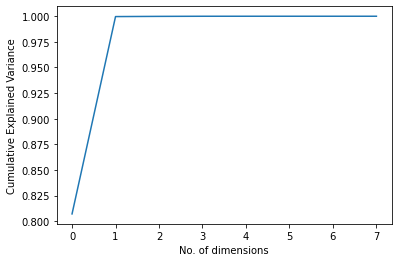

In [7]:
pca=PCA().fit(inputs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of dimensions')
plt.ylabel('Cumulative Explained Variance')

### PCA

We will now reduce the dimensionality of the data (both testing and training sets)

In [8]:
pca = PCA(1)  

inputsPCA = pca.fit_transform(inputs)

In [9]:
inputsPCA.shape

(768, 1)

### Plot Some Data

We can see from the bellow plot that for these two input metrics there is wildly different scales. One is between 0.5 to 1 and the other 500 to 900.

We need to scale this data using one of sk learns scaller. We will use the  

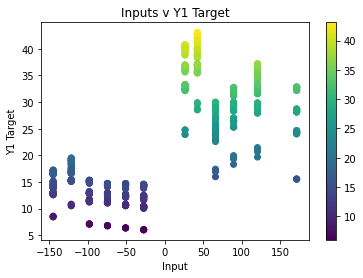

In [10]:
plt.figure()
plt.scatter(inputsPCA[:,0], targets[:,:1], c= targets[:,0])
plt.title("Inputs v Y1 Target")
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Y1 Target')
plt.show()

In [135]:
scaler = MinMaxScaler()

inputsScaled = scaler.fit_transform(inputsPCA)
inputsScaledNoPCA = scaler.fit_transform(inputs)

targets = scaler.fit_transform(targets)

We can now see that the data has been scalled so the minimum input/target value is now 0 and the maximum input/target value is 1.

This has the effect of spreading out the data, making it much easier for the model to find a good generalised solution.

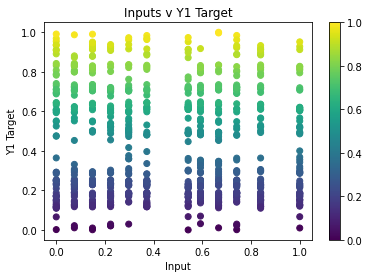

In [137]:
plt.figure()
plt.scatter(inputsScaled[:,0], targets[:,:1], c= targets[:,0])
plt.title("Inputs v Y1 Target")
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Y1 Target')
plt.show()

## Random Forest

In [138]:
rf = RandomForestRegressor()
rfCvPca = cross_validate(rf, inputsScaled, targets, cv=25, return_train_score=True, 
                         scoring='neg_mean_squared_error')

In [139]:
rf = RandomForestRegressor()
rfCvNoPca = cross_validate(rf, inputsScaledNoPCA, targets, cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

# wtf is going on bellow with the tables? are they mixed up - also use abs() to make arrs pos

In [140]:
rfResultsTrain = {"RF w/ PCA - Test Score": rfCvPca['test_score'], 
                  "RF w/o PCA - Test Score": rfCvNoPca['test_score']}

rfResultsTest = {"RF w/ PCA - Train Score": rfCvPca['train_score'],
                 "RF w/o PCA - Train Score": rfCvNoPca['train_score']}

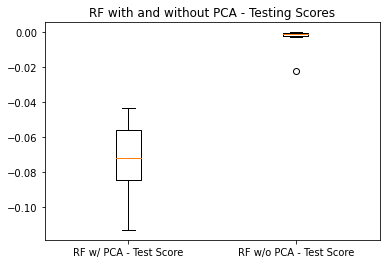

In [141]:
fig, ax = plt.subplots()
plt.title("RF with and without PCA - Testing Scores")
ax.boxplot(rfResultsTrain.values())
ax.set_xticklabels(rfResultsTrain.keys())
plt.show()

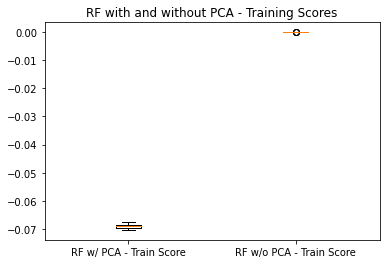

In [142]:
fig, ax = plt.subplots()
plt.title("RF with and without PCA - Training Scores")
ax.boxplot(rfResultsTest.values())
ax.set_xticklabels(rfResultsTest.keys())
plt.show()

### Random Forest Results

The random forset produced some unusual results, it performed much better on the data that had not undergone PCA compared to the data which was reduced down to 1 dimension. 

The non-reduced dataset has a much lower average error on the test data, -2 compared to -8 for the reduced dataset. It also had a much smaller IQR of around 1.8 compared to 3 for the reduced dataset.

## Neural Network

In [143]:
regressor = MLPRegressor(max_iter=15000)
nnCvPca = cross_validate(regressor, inputsScaled, targets, cv=25, return_train_score=True, 
                         scoring='neg_mean_squared_error')

In [144]:
regressor = MLPRegressor(max_iter=15000)
nnCvNoPca = cross_validate(regressor, inputsScaledNoPCA, targets, cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [145]:
nnResultsTrain = {"NN w/ PCA - Test Score": nnCvPca['test_score'], 
                  "NN w/o PCA - Test Score": nnCvNoPca['test_score']}

nnResultsTest = {"NN w/ PCA - Train Score": nnCvPca['train_score'],
                  "NN w/o PCA - Train Score": nnCvNoPca['train_score']}

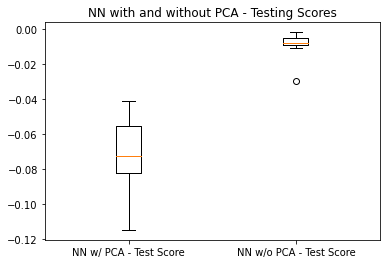

In [146]:
fig, ax = plt.subplots()
plt.title("NN with and without PCA - Testing Scores")
ax.boxplot(nnResultsTrain.values())
ax.set_xticklabels(nnResultsTrain.keys())
plt.show()

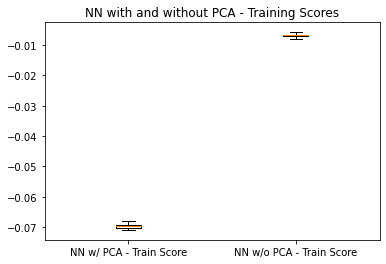

In [147]:
fig, ax = plt.subplots()
plt.title("NN with and without PCA - Training Scores")
ax.boxplot(nnResultsTest.values())
ax.set_xticklabels(nnResultsTest.keys())
plt.show()

### Neural Network Results

The neural network also produced some unusual results, again performing much better on the data that had not undergone PCA compared to the data which was reduced down to 1 dimension. 

The non-reduced dataset has a much lower average error on the test data, -2.2 compared to -20 for the reduced dataset. It also had a much smaller IQR of around 3 compared to 24 for the reduced dataset.

## Support Vector Machine

The SVM can only predict a single output variable, because our dataset has two output variables (Y1 and Y2) we need to train two seperate SVMs.

### Y1

In [148]:
svr = svm.SVR(gamma="auto")
svmCvPca_y1 = cross_validate(svr, inputsScaled, targets_y1.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [149]:
svr = svm.SVR(gamma="auto")
svmCvNoPca_y1 = cross_validate(svr, inputsScaledNoPCA, targets_y1.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [150]:
svmResultsTrain_y1 = {"SVM w/ PCA - Test Score": svmCvPca_y1['test_score'], 
                  "SVM w/o PCA - Test Score": svmCvNoPca_y1['test_score']}

svmResultsTest_y1 = {"SVM w/ PCA - Train Score": svmCvPca_y1['train_score'],
                  "SVM w/o PCA - Train Score": svmCvNoPca_y1['train_score']}

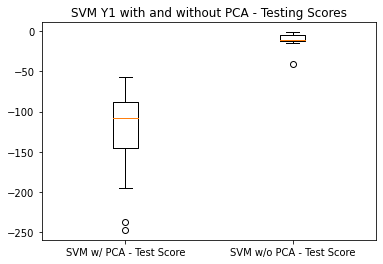

In [151]:
fig, ax = plt.subplots()
plt.title("SVM Y1 with and without PCA - Testing Scores")
ax.boxplot(svmResultsTrain_y1.values())
ax.set_xticklabels(svmResultsTrain_y1.keys())
plt.show()

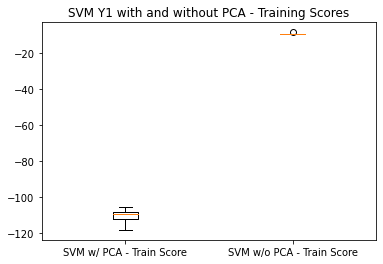

In [152]:
fig, ax = plt.subplots()
plt.title("SVM Y1 with and without PCA - Training Scores")
ax.boxplot(svmResultsTest_y1.values())
ax.set_xticklabels(svmResultsTest_y1.keys())
plt.show()

### Y2

In [153]:
svr = svm.SVR(gamma="auto")
svmCvPca_y2 = cross_validate(svr, inputsScaled, targets_y2.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [154]:
supportVectorMachine = svm.SVR(gamma="auto")
svmCvNoPca_y2 = cross_validate(svr, inputsScaledNoPCA, targets_y2.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [155]:
svmResultsTrain_y2 = {"SVM w/ PCA - Test Score": svmCvPca_y2['test_score'], 
                  "SVM w/o PCA - Test Score": svmCvNoPca_y2['test_score']}

svmResultsTest_y2 = {"SVM w/ PCA - Train Score": svmCvPca_y2['train_score'],
                  "SVM w/o PCA - Train Score": svmCvNoPca_y2['train_score']}

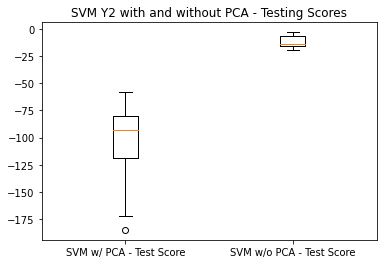

In [156]:
fig, ax = plt.subplots()
plt.title("SVM Y2 with and without PCA - Testing Scores")
ax.boxplot(svmResultsTrain_y2.values())
ax.set_xticklabels(svmResultsTrain_y2.keys())
plt.show()

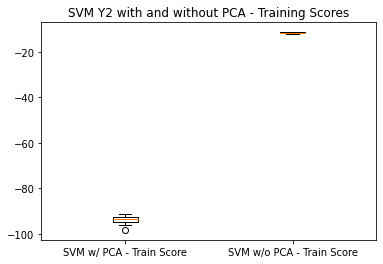

In [157]:
fig, ax = plt.subplots()
plt.title("SVM Y2 with and without PCA - Training Scores")
ax.boxplot(svmResultsTest_y2.values())
ax.set_xticklabels(svmResultsTest_y2.keys())
plt.show()

### Support Vector Machine Results

# double check

The support vector machine did not produce the same interesting results as seen with the random forest and neural network. With the average for Y1 and Y2 being approximatly -90 and -100 respectivly, with little difference between the reduced and non-reduced dataset.

Both had an IQR around thr 30 to 40 mark, again with little difference between the reduced and non reduced data.

## Overall Results

In summary the random forest is probably the best choice, it has the best average score, and a small IQR. It is also less computationaly intensive than the similarly performing neural network - the random forest takes ~3s to train vs ~25s to train the neural network.

SVM is a clear third place however, with drastically worse average scores than the neural network and random forest.

## PCA Anomalies 

It's not competly clear why the classifieres all train poorly on the reduced dataset, regardless of the CEV graph showing that 1 dimension should represent all of the variance in the data. Presumably there is some element of the data that isn't well represented when scaled down using PCA. 

# Part 2 - Optimisation

Implement an optimiser to solve a timetabling problem for a university. A file has been provided that describes modules, and lists modules against which they cannot be scheduled. A module **consists of one lecture per week and one or more lab sessions**.

Optimise a timetable so that session is scheduled once per week in such a way that
timetable constraints are minimised. There are **20 sessions per week**. You have **one lecture theatre
and two labs available**.

Relevant constraints for this assessment are:

- A session cannot be scheduled for a time when any of its students or staff are in another session (concurrence constraints). The sessions for a module that clash are shown in the data file.
- A lab session cannot occur in the week before its corresponding lecture has taken place (precedence constraints).

You must design and implement a fitness function by taking the **number of the concurrence constraints and multiplying them with the number of precedence constraints**. This fitness function should be minimised – the ideal timetable is one with no constraint violations at all, in which case the function will return 0 (NOTE: This is now 1, as.............................)

## Task 2.1 – Generation of random solutions (10% of total mark)

The first task is to implement the fitness function. Your code should read the file provided and given
a timetable it should return the quality of the schedule in terms of the constraint violations, as described
above. The function should be called the fitness of a random solution printed out.

NOTE - I have assumed that a lecture can take place in a lab, but a lab cannot take place in a lecture theatre

## Task 2.2 – Algorithm implementation (25% of total mark)

Implement a hillclimber to optimise the problem implemented in Task 2.1.

The algorithm must have the following features:

- It should be possible to use one of two mutation operators – one (session replace) mutates a solution by placing a session into another slot in the timetable, and the other is a ruin-andrecreate operator (which generates a completely new solution at random).
- At each iteration your single parent solution should be used to generate a single child operator by using one of the mutation operators (either the swap or the ruin-and-recreate for the entire run of the algorithm).
- At the end of an iteration the algorithm should retain the parent or child that has the best fitness.
- At the end of an iteration the best (parent or child) solution’s fitness should be added to a list of the best fitnesses, which is returned along with the best solution at the end of the optimisation.

## Task 2.3 – Visualisation of results (15% of total mark)

Run the algorithm twice for 500 iterations – once for each mutation operator. Repeat this 30 times, so that you get 30 fitness lists for the swap operator and 30 fitness lists for the ruin-andrecreate operator. 

Plot the average, maximum and minimum fitness at each iteration for each operator, plot them on the same graph so that they can be compared. 

You should be able to see which optimiser is best – state which in the notebook, and say why.

## Import the Modules

In [1]:
def makeModule(line):
    m = {"code": "",
         "lecturer":"",
         "labs":0,
         "noclash":[]
        }
    
    m["code"] = line[:6]
    
    lecture = line[7:]
    count = 7
    for c in lecture:
        if c == "|":
            break
        count = count + 1
    
    m["lecturer"] = line[7:count]
        
    m["labs"] = line[count+1:count+2]
    
    
    m["noclash"] = line[count+3:].split(",")
        
    
    
    
    
    return m

In [2]:
f = open('modules.txt', 'r')
Lines = f.readlines()

modulesList = []
 
for line in Lines:
    m = makeModule(line.strip())
    modulesList.append(m)

Modules is an array of dictionaries that contain the code, lecture, number of labs and an array of modules it cannot clash with

In [3]:
modulesList

[{'code': 'MOD001',
  'lecturer': 'Zacharias Karstensen',
  'labs': '2',
  'noclash': ['MOD002',
   'MOD003',
   'MOD004',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD013']},
 {'code': 'MOD002',
  'lecturer': 'Dominykas Cleary',
  'labs': '2',
  'noclash': ['MOD001',
   'MOD003',
   'MOD004',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD013']},
 {'code': 'MOD003',
  'lecturer': 'Zacharias Karstensen',
  'labs': '2',
  'noclash': ['MOD001',
   'MOD002',
   'MOD004',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD011',
   'MOD012',
   'MOD013']},
 {'code': 'MOD004',
  'lecturer': 'Laila Deniau',
  'labs': '1',
  'noclash': ['MOD001',
   'MOD002',
   'MOD003',
   'MOD005',
   'MOD006',
   'MOD007',
   'MOD008',
   'MOD009',
   'MOD010',
   'MOD011',
   'MOD012',
   'MOD013']},
 {'code': 'MOD005',
  'lecturer': 'Brahma O Braonain',
  'labs': '2',
  'noclash': ['MOD001',
  

We now have the modules in a data structure that we can work with

We need to create another data structure that can represent the different labs and lecture rooms.

In [4]:
def blankWeek():
    return [
    {
        "day": "Monday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Tuesday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Wednesday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Thursday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    },
    {
        "day": "Friday",
        "theatre": [None, None, None, None],
        "lab1": [None, None, None, None],
        "lab2": [None, None, None, None]
    }
]

The Week is an array of 5 dictionaries whcih contain keys for the day, and each of the rooms (lecture theatre, and the two labs). These have an array, which will then be populated by the module codes (but has a default of None for now)

## Generate a Random Solution

This function has to take in the array of all modules and the number of labs, and create a random solution.

It creates a random solution by selecting a random day and session (and room in the case of labs) and inserting a lecture/lab from the list.

NOTE: Each time this is ran you need to make sure you also run the code above (where the week variable is set) to create a new empty week otherwise this code loops forever. ***THIS NEEDS TO BE FIXED BEFORE THE DEADLINE***

In [5]:
import random

def randomSolution(modules):
    lectures = []
    labs = []
    
    newWeek = blankWeek()
    
    
    
    for d in modules:
        lectures.append(d["code"])
        for i in range(int(d["labs"])):
            labs.append(d["code"])    
    
    while len(lectures) > 0:
        module = lectures[0]
        
        day = random.randrange(0, 5)
        session = random.randrange(0,4)

        if newWeek[day]["theatre"][session] == None:
            newWeek[day]["theatre"][session] = module
            lectures.pop(0)
    
    while len(labs) > 0:
        module = labs[0]
        
        day = random.randrange(0, 5)
        room = random.randrange(0,2)
        session = random.randrange(0,4)
                
        if room == 0:
            if newWeek[day]["lab1"][session] == None:
                newWeek[day]["lab1"][session] = module
                labs.pop(0)
        elif room == 1:
            if newWeek[day]["lab2"][session] == None:
                newWeek[day]["lab2"][session] = module
                labs.pop(0)
        

    return newWeek

In [6]:
week = randomSolution(modulesList)

week

[{'day': 'Monday',
  'theatre': ['MOD007', 'MOD011', None, 'MOD002'],
  'lab1': ['MOD010', 'MOD004', None, 'MOD009'],
  'lab2': ['MOD014', None, 'MOD011', 'MOD012']},
 {'day': 'Tuesday',
  'theatre': [None, 'MOD012', 'MOD013', 'MOD017'],
  'lab1': ['MOD007', None, 'MOD003', None],
  'lab2': ['MOD013', 'MOD005', 'MOD014', None]},
 {'day': 'Wednesday',
  'theatre': ['MOD008', 'MOD001', 'MOD006', None],
  'lab1': ['MOD001', 'MOD010', 'MOD002', 'MOD006'],
  'lab2': [None, None, 'MOD012', 'MOD008']},
 {'day': 'Thursday',
  'theatre': ['MOD004', 'MOD003', 'MOD014', 'MOD005'],
  'lab1': ['MOD015', 'MOD005', None, None],
  'lab2': ['MOD009', 'MOD008', 'MOD001', 'MOD006']},
 {'day': 'Friday',
  'theatre': ['MOD009', 'MOD015', 'MOD016', 'MOD010'],
  'lab1': ['MOD006', 'MOD002', 'MOD017', 'MOD003'],
  'lab2': ['MOD016', 'MOD009', 'MOD015', 'MOD011']}]

### Fitness Function

This function takes the week and outputs a value of fitness for the week

In [228]:
def room(number):
    if number == 0:
        return "theatre"
    elif number == 1:
        return "lab1"
    elif number == 2:
        return "lab2"

def moduleNoClash(module, modules):
    for m in modules:
        if m["code"] == module:
            return m["noclash"]

def fitness(wk):
    cC = 1 #number of concurence constrain violations
    pC = 1 #number of precendece constrain violations
    
    weekToFitness = copy.deepcopy(wk)
    
    # check concurence constraints
    for d in range(0,5):
        for r in range(0,3):
            for s in range(0,4):
                toCheck = moduleNoClash(weekToFitness[d][room(r)][s], modulesList)
                
                #if this slot has a module
                if(toCheck != None):
                    #check all the other rooms
                    #apart from the room the module currently being checked is in
                    
                    if(s != 0):
                        # check room leacture room
                        sessionModule = weekToFitness[d][room(0)][s]
                        for noClash in toCheck:
                            if noClash == sessionModule:
                                #add a concurence constraint violation
                                cC = cC + 1
                                
                    elif(s != 1):
                        # check room lab 1
                        sessionModule = weekToFitness[d][room(1)][s]
                        for noClash in toCheck:
                            if noClash == sessionModule:
                                #add a concurence constraint violation
                                cC = cC + 1
                                
                    elif(s != 2):
                        # check lab 2
                        sessionModule = weekToFitness[d][room(2)][s]
                        for noClash in toCheck:
                            if noClash == sessionModule:
                                #add a concurence constraint violation
                                cC = cC + 1
    
    # check precedence violation
    # loop through all the lectures
    for d1 in range(0,5):
        for s1 in range(0,4):
            lectureCode = weekToFitness[d1][room(0)][s1]
            
            #search through all labs that happen before the lecture
            for d2 in range(0,d1):
                for r in range(1,3):
                    for s2 in range(0,4):
                        if(s2 > s1 and d2 == d1):
                            # if this is true, then we are checking a session that is on the same day
                            # but after the lecture, these are valid so do not need to be checked
                            # so just break out of the loop
                            break
                        else:
                            if(lectureCode == weekToFitness[d][room(r)][s]):
                                pC = pC + 1
            
                            
            
    
    return cC * pC

                        

In [8]:
fitness(week)

221

### Mutation Function

In [229]:
def mutate(wk, mutationType):
    
    weekToMutate = copy.deepcopy(wk)
    
    if(mutationType == "sr"):
        # session replacement
        # choose a random session
        
        # two random sessions
        # the first shall not be empty, the second can be empty
        
        moduleA = None
        while moduleA == None:
            dayA = random.randrange(0, 5)
            roomA = random.randrange(0,3)
            sessionA = random.randrange(0,4)
            moduleA = weekToMutate[dayA][room(roomA)][sessionA]      
        
        dayB = random.randrange(0, 5)
        roomB = random.randrange(0,3)
        sessionB = random.randrange(0,4)
        
        moduleB = weekToMutate[dayB][room(roomB)][sessionB]
        
        # swap
        weekToMutate[dayA][room(roomA)][sessionA] = moduleB
        weekToMutate[dayB][room(roomB)][sessionB] = moduleA
         
        return weekToMutate
        
    elif(mutationType == "rr"):
        # ruin and recreate
    
        return randomSolution(modulesList)
    
    else:
        print("Mutation type not valid")
        return blankWeek()
    

In [230]:
fitness(mutate(week,"sr"))

221

### Hill Climber

In [231]:
import copy
import json

def hillclimber(mutationType, iterations):
    fitnesses = []
    
    parent = randomSolution(modulesList)
    parentFitness = fitness(parent)
    
    for i in range(iterations): 
        child = copy.deepcopy(mutate(parent, mutationType))
        childFitness = fitness(child)
        
        print("Parent: " +str(parentFitness))
        print("Child: " + str(childFitness))
        print() 
        
        if childFitness < parentFitness:
            parentFitness = childFitness
            parent = copy.deepcopy(child) # this line has errors
            
        fitnesses.append(parentFitness)

    return fitnesses, parent

In [232]:
fitnesses, bestWeek = hillclimber("sr", 500)

Parent: 80
Child: 75

Parent: 75
Child: 70

Parent: 70
Child: 75

Parent: 70
Child: 204

Parent: 70
Child: 70

Parent: 70
Child: 65

Parent: 65
Child: 65

Parent: 65
Child: 65

Parent: 65
Child: 65

Parent: 65
Child: 65

Parent: 65
Child: 80

Parent: 65
Child: 70

Parent: 65
Child: 65

Parent: 65
Child: 70

Parent: 65
Child: 169

Parent: 65
Child: 70

Parent: 65
Child: 65

Parent: 65
Child: 13

Parent: 13
Child: 13

Parent: 13
Child: 14

Parent: 13
Child: 13

Parent: 13
Child: 13

Parent: 13
Child: 14

Parent: 13
Child: 13

Parent: 13
Child: 13

Parent: 13
Child: 15

Parent: 13
Child: 12

Parent: 12
Child: 12

Parent: 12
Child: 11

Parent: 11
Child: 13

Parent: 11
Child: 11

Parent: 11
Child: 11

Parent: 11
Child: 10

Parent: 10
Child: 10

Parent: 10
Child: 10

Parent: 10
Child: 10

Parent: 10
Child: 11

Parent: 10
Child: 11

Parent: 10
Child: 12

Parent: 10
Child: 10

Parent: 10
Child: 11

Parent: 10
Child: 11

Parent: 10
Child: 10

Parent: 10
Child: 12

Parent: 10
Child: 11

Parent: 

In [233]:
fitnesses

[75,
 70,
 70,
 70,
 70,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 

In [234]:
bestWeek

[{'day': 'Monday',
  'theatre': ['MOD011', 'MOD005', 'MOD013', 'MOD011'],
  'lab1': ['MOD002', None, 'MOD015', 'MOD010'],
  'lab2': ['MOD011', None, None, None]},
 {'day': 'Tuesday',
  'theatre': ['MOD010', 'MOD013', 'MOD015', 'MOD017'],
  'lab1': ['MOD016', 'MOD014', 'MOD002', 'MOD006'],
  'lab2': ['MOD009', 'MOD008', None, 'MOD009']},
 {'day': 'Wednesday',
  'theatre': ['MOD015', None, None, None],
  'lab1': ['MOD005', 'MOD009', 'MOD006', 'MOD003'],
  'lab2': ['MOD017', 'MOD012', 'MOD003', 'MOD004']},
 {'day': 'Thursday',
  'theatre': ['MOD003', 'MOD001', 'MOD016', 'MOD006'],
  'lab1': [None, 'MOD001', 'MOD012', 'MOD006'],
  'lab2': ['MOD004', 'MOD001', 'MOD010', None]},
 {'day': 'Friday',
  'theatre': ['MOD012', 'MOD007', None, 'MOD002'],
  'lab1': [None, 'MOD005', 'MOD008', 'MOD014'],
  'lab2': ['MOD009', 'MOD007', 'MOD014', 'MOD008']}]

In [235]:
fitness(bestWeek)

3

### Repeate 30 times for each mutation type, calculate max, min and avg

In [181]:
bestFitnessSr = []
bestFitnessRr = []

bestWeekSr = []
bestWeekRr = []

resultsSr = []


resultsRr = []

for i in range (30):
    bestFitnessSrOutput, bestWeekSrOutput = hillclimber("sr", 500)
    bestFitnessSr.append(bestFitnessSrOutput)
    bestWeekSr.append(bestWeekSrOutput)
    
    bestFitnessRrOutput, bestWeekRrOutput = hillclimber("rr", 500)
    bestFitnessRr.append(bestFitnessRrOutput)
    bestWeekRr.append(bestWeekRrOutput)
    
    maxSr.append(max(bestFitnessSr[i]))
    minSr.append(min(bestFitnessSr[i]))
    avgSr.append(sum(bestFitnessSr[i])/len(bestFitnessSr[i]))
    
    arr = [max(bestFitnessSr[i]), sum(bestFitnessSr[i])/len(bestFitnessSr[i]), min(bestFitnessSr[i])]
    resultsSr.append(arr)
    
    
    maxRr.append(max(bestFitnessRr[i]))
    avgRr.append(sum(bestFitnessRr[i])/len(bestFitnessRr[i]))
    minRr.append(min(bestFitnessRr[i]))
    
    arr = [max(bestFitnessRr[i]),  sum(bestFitnessRr[i])/len(bestFitnessRr[i]), min(bestFitnessRr[i])]
    resultsRr.append(arr)
    

Parent: 528
Child: 594

Parent: 528
Child: 594

Parent: 528
Child: 627

Parent: 528
Child: 594

Parent: 528
Child: 561

Parent: 528
Child: 561

Parent: 528
Child: 561

Parent: 528
Child: 528

Parent: 528
Child: 528

Parent: 528
Child: 969

Parent: 528
Child: 1026

Parent: 528
Child: 969

Parent: 528
Child: 912

Parent: 528
Child: 1026

Parent: 528
Child: 1026

Parent: 528
Child: 969

Parent: 528
Child: 1026

Parent: 528
Child: 1296

Parent: 528
Child: 1296

Parent: 528
Child: 1539

Parent: 528
Child: 1458

Parent: 528
Child: 969

Parent: 528
Child: 1026

Parent: 528
Child: 969

Parent: 528
Child: 969

Parent: 528
Child: 912

Parent: 528
Child: 969

Parent: 528
Child: 969

Parent: 528
Child: 912

Parent: 528
Child: 855

Parent: 528
Child: 855

Parent: 528
Child: 855

Parent: 528
Child: 855

Parent: 528
Child: 855

Parent: 528
Child: 855

Parent: 528
Child: 912

Parent: 528
Child: 528

Parent: 528
Child: 561

Parent: 528
Child: 594

Parent: 528
Child: 627

Parent: 528
Child: 660

Parent:

Child: 16

Parent: 14
Child: 80

Parent: 14
Child: 80

Parent: 14
Child: 85

Parent: 14
Child: 85

Parent: 14
Child: 85

Parent: 14
Child: 85

Parent: 14
Child: 85

Parent: 14
Child: 80

Parent: 14
Child: 80

Parent: 14
Child: 80

Parent: 14
Child: 16

Parent: 14
Child: 18

Parent: 14
Child: 18

Parent: 14
Child: 17

Parent: 14
Child: 17

Parent: 14
Child: 16

Parent: 14
Child: 208

Parent: 14
Child: 221

Parent: 14
Child: 221

Parent: 14
Child: 234

Parent: 14
Child: 234

Parent: 14
Child: 234

Parent: 14
Child: 208

Parent: 14
Child: 195

Parent: 14
Child: 195

Parent: 14
Child: 182

Parent: 14
Child: 208

Parent: 14
Child: 208

Parent: 14
Child: 289

Parent: 14
Child: 289

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 255

Parent: 14
Child: 255

Parent: 14
Child: 238

Parent: 14
Child: 255

Parent: 14
Child: 255

Parent: 14
Child: 126

Parent: 14
Child: 126

Parent: 14
Child: 126

Parent: 14
Child: 135

Parent: 14
Child: 144

Parent: 14
Child

Parent: 17
Child: 16

Parent: 16
Child: 16

Parent: 16
Child: 16

Parent: 16
Child: 15

Parent: 15
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 13

Parent: 13
Child: 14

Parent: 13
Child: 14

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 208

Parent: 13
Child: 221

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 70

Parent: 13
Child: 75

Parent: 13
Child: 75

Parent: 13
Child: 75

Parent: 13
Child: 75

Parent: 13
Child: 14

Parent: 13
Child: 13

Parent: 13
Child: 14

Parent: 13
Child: 12

Parent: 12
Child: 12

Parent: 12
Child: 13

Parent: 12
Child: 14

Parent: 12
Child: 14

Parent: 12
Child: 15

Parent: 12
Child: 16

Parent: 12
Child: 17

Parent: 12
Child: 18

Parent: 12
Child: 18

Parent: 12
Child: 19

Parent: 12
Child: 19

Parent: 12
Child: 19

Parent: 12
Child: 20

Parent: 12
Child: 21

Parent: 


Parent: 144
Child: 153

Parent: 144
Child: 162

Parent: 144
Child: 162

Parent: 144
Child: 171

Parent: 144
Child: 153

Parent: 144
Child: 162

Parent: 144
Child: 180

Parent: 144
Child: 180

Parent: 144
Child: 180

Parent: 144
Child: 180

Parent: 144
Child: 180

Parent: 144
Child: 399

Parent: 144
Child: 399

Parent: 144
Child: 399

Parent: 144
Child: 399

Parent: 144
Child: 420

Parent: 144
Child: 420

Parent: 144
Child: 441

Parent: 144
Child: 189

Parent: 144
Child: 189

Parent: 144
Child: 273

Parent: 144
Child: 260

Parent: 144
Child: 273

Parent: 144
Child: 273

Parent: 144
Child: 189

Parent: 144
Child: 189

Parent: 144
Child: 189

Parent: 144
Child: 180

Parent: 144
Child: 162

Parent: 144
Child: 144

Parent: 144
Child: 144

Parent: 144
Child: 144

Parent: 144
Child: 135

Parent: 135
Child: 144

Parent: 135
Child: 126

Parent: 126
Child: 126

Parent: 126
Child: 126

Parent: 126
Child: 117

Parent: 117
Child: 117

Parent: 117
Child: 117

Parent: 117
Child: 126

Parent: 117
Chi

Child: 495

Parent: 14
Child: 495

Parent: 14
Child: 495

Parent: 14
Child: 528

Parent: 14
Child: 528

Parent: 14
Child: 561

Parent: 14
Child: 495

Parent: 14
Child: 294

Parent: 14
Child: 336

Parent: 14
Child: 315

Parent: 14
Child: 315

Parent: 14
Child: 315

Parent: 14
Child: 294

Parent: 14
Child: 273

Parent: 14
Child: 315

Parent: 14
Child: 315

Parent: 14
Child: 315

Parent: 14
Child: 378

Parent: 14
Child: 378

Parent: 14
Child: 336

Parent: 14
Child: 294

Parent: 14
Child: 315

Parent: 14
Child: 336

Parent: 14
Child: 315

Parent: 14
Child: 315

Parent: 14
Child: 315

Parent: 14
Child: 336

Parent: 14
Child: 336

Parent: 14
Child: 336

Parent: 14
Child: 561

Parent: 14
Child: 561

Parent: 14
Child: 561

Parent: 14
Child: 594

Parent: 14
Child: 660

Parent: 14
Child: 660

Parent: 14
Child: 420

Parent: 14
Child: 441

Parent: 14
Child: 420

Parent: 14
Child: 441

Parent: 14
Child: 462

Parent: 14
Child: 483

Parent: 14
Child: 483

Parent: 14
Child: 462

Parent: 14
Child: 462


Child: 90

Parent: 13
Child: 90

Parent: 13
Child: 80

Parent: 13
Child: 85

Parent: 13
Child: 80

Parent: 13
Child: 90

Parent: 13
Child: 95

Parent: 13
Child: 95

Parent: 13
Child: 95

Parent: 13
Child: 90

Parent: 13
Child: 90

Parent: 13
Child: 90

Parent: 13
Child: 90

Parent: 13
Child: 95

Parent: 13
Child: 95

Parent: 13
Child: 95

Parent: 13
Child: 90

Parent: 13
Child: 80

Parent: 13
Child: 80

Parent: 13
Child: 85

Parent: 13
Child: 85

Parent: 13
Child: 153

Parent: 13
Child: 153

Parent: 13
Child: 162

Parent: 13
Child: 162

Parent: 13
Child: 162

Parent: 13
Child: 153

Parent: 13
Child: 162

Parent: 13
Child: 162

Parent: 13
Child: 153

Parent: 13
Child: 144

Parent: 13
Child: 126

Parent: 13
Child: 126

Parent: 13
Child: 126

Parent: 13
Child: 126

Parent: 13
Child: 273

Parent: 13
Child: 252

Parent: 13
Child: 252

Parent: 13
Child: 273

Parent: 13
Child: 273

Parent: 13
Child: 252

Parent: 13
Child: 273

Parent: 13
Child: 273

Parent: 13
Child: 273

Parent: 13
Child: 27

Parent: 182
Child: 182

Parent: 182
Child: 195

Parent: 182
Child: 195

Parent: 182
Child: 195

Parent: 182
Child: 195

Parent: 182
Child: 182

Parent: 182
Child: 169

Parent: 169
Child: 65

Parent: 65
Child: 70

Parent: 65
Child: 75

Parent: 65
Child: 75

Parent: 65
Child: 75

Parent: 65
Child: 70

Parent: 65
Child: 65

Parent: 65
Child: 55

Parent: 55
Child: 60

Parent: 55
Child: 65

Parent: 55
Child: 70

Parent: 55
Child: 75

Parent: 55
Child: 75

Parent: 55
Child: 70

Parent: 55
Child: 70

Parent: 55
Child: 80

Parent: 55
Child: 85

Parent: 55
Child: 85

Parent: 55
Child: 306

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 522

Parent: 55
Child: 522

Parent: 55
Child: 493

Parent: 55
Child: 493

Parent: 55
Child: 464

Parent: 55
Child: 493

Parent: 55
Child: 522

Parent: 55
Child: 561

Parent: 55
Child: 561

Parent: 55
Child: 594

Parent: 55
Child: 561


Parent: 11
Child: 435

Parent: 11
Child: 435

Parent: 11
Child: 435

Parent: 11
Child: 493

Parent: 11
Child: 522

Parent: 11
Child: 551

Parent: 11
Child: 551

Parent: 11
Child: 340

Parent: 11
Child: 357

Parent: 11
Child: 340

Parent: 11
Child: 357

Parent: 11
Child: 357

Parent: 11
Child: 357

Parent: 11
Child: 323

Parent: 11
Child: 340

Parent: 11
Child: 340

Parent: 11
Child: 323

Parent: 11
Child: 323

Parent: 11
Child: 340

Parent: 11
Child: 323

Parent: 11
Child: 323

Parent: 11
Child: 323

Parent: 11
Child: 306

Parent: 11
Child: 306

Parent: 11
Child: 323

Parent: 11
Child: 340

Parent: 11
Child: 357

Parent: 11
Child: 323

Parent: 11
Child: 340

Parent: 11
Child: 357

Parent: 11
Child: 340

Parent: 11
Child: 357

Parent: 11
Child: 357

Parent: 11
Child: 357

Parent: 11
Child: 340

Parent: 11
Child: 340

Parent: 11
Child: 323

Parent: 11
Child: 306

Parent: 11
Child: 289

Parent: 11
Child: 272

Parent: 11
Child: 272

Parent: 11
Child: 272

Parent: 11
Child: 272

Parent: 11

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 238

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 238

Parent: 17
Child: 221

Parent: 17
Child: 255

Parent: 17
Child: 272

Parent: 17
Child: 272

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 255

Parent: 17
Child: 15

Parent: 15
Child: 16

Parent: 15
Child: 15

Parent: 15
Child: 15

Parent: 15
Child: 15

Parent: 15
Child: 15

Parent: 15
Child: 16

Parent: 15
Child: 16

Parent: 15
Child: 17

Parent: 15
Child: 17

Parent: 15
Child: 16

Parent: 15
Child: 17

Parent: 15
Child: 17

Parent: 15
Child: 17

Parent: 15
Child: 18

Parent: 15
Child: 18

Parent: 15
Child: 18

Parent: 15
Child: 18

Parent: 15
Child: 16

Parent: 15
Child: 16

Parent: 15
Child: 16

Parent: 15
Child: 272

Parent: 15
Child: 306

Parent: 15
Child: 306

Parent: 15
Child: 306

Parent: 15
Child: 306

Parent: 15
Child: 306

Parent: 1

Child: 80

Parent: 10
Child: 85

Parent: 10
Child: 18

Parent: 10
Child: 16

Parent: 10
Child: 17

Parent: 10
Child: 17

Parent: 10
Child: 16

Parent: 10
Child: 16

Parent: 10
Child: 16

Parent: 10
Child: 15

Parent: 10
Child: 14

Parent: 10
Child: 15

Parent: 10
Child: 14

Parent: 10
Child: 255

Parent: 10
Child: 238

Parent: 10
Child: 238

Parent: 10
Child: 238

Parent: 10
Child: 221

Parent: 10
Child: 204

Parent: 10
Child: 221

Parent: 10
Child: 238

Parent: 10
Child: 238

Parent: 10
Child: 238

Parent: 10
Child: 255

Parent: 10
Child: 272

Parent: 10
Child: 272

Parent: 10
Child: 221

Parent: 10
Child: 221

Parent: 10
Child: 221

Parent: 10
Child: 336

Parent: 10
Child: 357

Parent: 10
Child: 357

Parent: 10
Child: 378

Parent: 10
Child: 378

Parent: 10
Child: 162

Parent: 10
Child: 144

Parent: 10
Child: 153

Parent: 10
Child: 153

Parent: 10
Child: 306

Parent: 10
Child: 323

Parent: 10
Child: 289

Parent: 10
Child: 289

Parent: 10
Child: 289

Parent: 10
Child: 289

Parent: 10
C


Parent: 11
Child: 221

Parent: 11
Child: 221

Parent: 11
Child: 234

Parent: 11
Child: 247

Parent: 11
Child: 247

Parent: 11
Child: 260

Parent: 11
Child: 260

Parent: 11
Child: 247

Parent: 11
Child: 260

Parent: 11
Child: 247

Parent: 11
Child: 234

Parent: 11
Child: 234

Parent: 11
Child: 234

Parent: 11
Child: 234

Parent: 11
Child: 234

Parent: 11
Child: 323

Parent: 11
Child: 399

Parent: 11
Child: 378

Parent: 11
Child: 399

Parent: 11
Child: 399

Parent: 11
Child: 378

Parent: 11
Child: 357

Parent: 11
Child: 399

Parent: 11
Child: 420

Parent: 11
Child: 441

Parent: 11
Child: 441

Parent: 11
Child: 441

Parent: 11
Child: 441

Parent: 11
Child: 378

Parent: 11
Child: 627

Parent: 11
Child: 627

Parent: 11
Child: 660

Parent: 11
Child: 660

Parent: 11
Child: 900

Parent: 11
Child: 855

Parent: 11
Child: 855

Parent: 11
Child: 900

Parent: 11
Child: 900

Parent: 11
Child: 900

Parent: 11
Child: 945

Parent: 11
Child: 945

Parent: 11
Child: 945

Parent: 11
Child: 900

Parent: 11

Child: 495

Parent: 13
Child: 495

Parent: 13
Child: 462

Parent: 13
Child: 462

Parent: 13
Child: 528

Parent: 13
Child: 528

Parent: 13
Child: 495

Parent: 13
Child: 528

Parent: 13
Child: 561

Parent: 13
Child: 528

Parent: 13
Child: 375

Parent: 13
Child: 350

Parent: 13
Child: 375

Parent: 13
Child: 255

Parent: 13
Child: 255

Parent: 13
Child: 255

Parent: 13
Child: 238

Parent: 13
Child: 221

Parent: 13
Child: 70

Parent: 13
Child: 70

Parent: 13
Child: 70

Parent: 13
Child: 65

Parent: 13
Child: 169

Parent: 13
Child: 182

Parent: 13
Child: 182

Parent: 13
Child: 221

Parent: 13
Child: 208

Parent: 13
Child: 208

Parent: 13
Child: 195

Parent: 13
Child: 182

Parent: 13
Child: 195

Parent: 13
Child: 195

Parent: 13
Child: 182

Parent: 13
Child: 169

Parent: 13
Child: 169

Parent: 13
Child: 169

Parent: 13
Child: 325

Parent: 13
Child: 325

Parent: 13
Child: 294

Parent: 13
Child: 294

Parent: 13
Child: 294

Parent: 13
Child: 315

Parent: 13
Child: 315

Parent: 13
Child: 555

Par

Child: 208

Parent: 17
Child: 221

Parent: 17
Child: 234

Parent: 17
Child: 247

Parent: 17
Child: 20

Parent: 17
Child: 19

Parent: 17
Child: 18

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 22

Parent: 17
Child: 22

Parent: 17
Child: 22

Parent: 17
Child: 21

Parent: 17
Child: 21

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 21

Parent: 17
Child: 20

Parent: 17
Child: 19

Parent: 17
Child: 19

Parent: 17
Child: 19

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 20

Parent: 17
Child: 18

Parent: 17
Child: 19

Parent: 17
Child: 19

Parent: 17
Child: 18

Parent: 17
Child: 18

Parent: 17
Child: 18

Parent: 17
Child: 18

Parent: 17
Child: 18

Parent: 17
Child: 162

Parent: 17
Child: 18

Parent: 17
Child: 18

Parent: 17
Child: 18

Parent: 17
Child: 17

Parent: 17
Child: 17

Parent: 17
Child: 16

Parent: 16
Child: 18

Parent: 16
Child: 17

Parent: 16
Child: 17

Parent: 16
Child

Parent: 135
Child: 495

Parent: 135
Child: 637

Parent: 135
Child: 429

Parent: 135
Child: 429

Parent: 135
Child: 429

Parent: 135
Child: 533

Parent: 135
Child: 533

Parent: 135
Child: 533

Parent: 135
Child: 492

Parent: 135
Child: 492

Parent: 135
Child: 492

Parent: 135
Child: 492

Parent: 135
Child: 451

Parent: 135
Child: 451

Parent: 135
Child: 533

Parent: 135
Child: 492

Parent: 135
Child: 492

Parent: 135
Child: 492

Parent: 135
Child: 325

Parent: 135
Child: 325

Parent: 135
Child: 325

Parent: 135
Child: 300

Parent: 135
Child: 300

Parent: 135
Child: 300

Parent: 135
Child: 300

Parent: 135
Child: 492

Parent: 135
Child: 533

Parent: 135
Child: 533

Parent: 135
Child: 574

Parent: 135
Child: 574

Parent: 135
Child: 574

Parent: 135
Child: 615

Parent: 135
Child: 697

Parent: 135
Child: 1314

Parent: 135
Child: 1314

Parent: 135
Child: 1314

Parent: 135
Child: 1314

Parent: 135
Child: 1314

Parent: 135
Child: 1083

Parent: 135
Child: 1026

Parent: 135
Child: 1083

Parent: 

Parent: 90
Child: 90

Parent: 90
Child: 80

Parent: 80
Child: 80

Parent: 80
Child: 85

Parent: 80
Child: 85

Parent: 80
Child: 80

Parent: 80
Child: 16

Parent: 16
Child: 17

Parent: 16
Child: 17

Parent: 16
Child: 18

Parent: 16
Child: 18

Parent: 16
Child: 18

Parent: 16
Child: 18

Parent: 16
Child: 18

Parent: 16
Child: 18

Parent: 16
Child: 17

Parent: 16
Child: 15

Parent: 15
Child: 238

Parent: 15
Child: 255

Parent: 15
Child: 14

Parent: 14
Child: 15

Parent: 14
Child: 16

Parent: 14
Child: 17

Parent: 14
Child: 18

Parent: 14
Child: 306

Parent: 14
Child: 306

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 289

Parent: 14
Child: 289

Parent: 14
Child: 306

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 255

Parent: 14
Child: 238

Parent: 14
Child: 429

Parent: 14
Child: 462

Parent: 14
Child: 495

Parent: 14
Child: 528

Parent: 14
Child: 528

Parent: 14
Child: 528

Parent: 14
Child: 528

Parent: 14
Child: 528

Parent: 14
Child: 561

Parent: 14

Parent: 13
Child: 153

Parent: 13
Child: 375

Parent: 13
Child: 75

Parent: 13
Child: 19

Parent: 13
Child: 182

Parent: 13
Child: 400

Parent: 13
Child: 425

Parent: 13
Child: 594

Parent: 13
Child: 208

Parent: 13
Child: 294

Parent: 13
Child: 660

Parent: 13
Child: 615

Parent: 13
Child: 406

Parent: 13
Child: 1040

Parent: 13
Child: 493

Parent: 13
Child: 204

Parent: 13
Child: 357

Parent: 13
Child: 969

Parent: 13
Child: 20

Parent: 13
Child: 294

Parent: 13
Child: 375

Parent: 13
Child: 660

Parent: 13
Child: 630

Parent: 13
Child: 703

Parent: 13
Child: 126

Parent: 13
Child: 294

Parent: 13
Child: 779

Parent: 13
Child: 429

Parent: 13
Child: 153

Parent: 13
Child: 315

Parent: 13
Child: 420

Parent: 13
Child: 315

Parent: 13
Child: 410

Parent: 13
Child: 765

Parent: 13
Child: 399

Parent: 13
Child: 255

Parent: 13
Child: 697

Parent: 13
Child: 315

Parent: 13
Child: 1377

Parent: 13
Child: 378

Parent: 13
Child: 580

Parent: 13
Child: 493

Parent: 13
Child: 561

Parent: 13
C


Parent: 169
Child: 377

Parent: 169
Child: 294

Parent: 169
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 13

Parent: 13
Child: 15

Parent: 13
Child: 14

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 14

Parent: 13
Child: 15

Parent: 13
Child: 16

Parent: 13
Child: 16

Parent: 13
Child: 16

Parent: 13
Child: 17

Parent: 13
Child: 18

Parent: 13
Child: 19

Parent: 13
Child: 19

Parent: 13
Child: 18

Parent: 13
Child: 18

Parent: 13
Child: 18

Parent: 13
Child: 18

Parent: 13
Child: 17

Parent: 13
Child: 18

Parent: 13
Child: 17

Parent: 13
Child: 17

Parent: 13
Child: 16

Parent: 13
Child: 15

Parent: 13
Child: 16

Parent: 13
Child: 16

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 15

Parent: 13
Child: 16

Parent: 13
Child: 135

Parent: 13
Child: 135

Parent: 13
Child: 135

Parent: 13
Child: 135

Parent: 13
Child: 135

Parent: 13
Child: 144

Parent: 13
Child: 144

Parent: 13
Child: 1

Child: 1040

Parent: 294
Child: 1040

Parent: 294
Child: 375

Parent: 294
Child: 350

Parent: 294
Child: 375

Parent: 294
Child: 238

Parent: 238
Child: 238

Parent: 238
Child: 221

Parent: 221
Child: 221

Parent: 221
Child: 221

Parent: 221
Child: 255

Parent: 221
Child: 238

Parent: 221
Child: 221

Parent: 221
Child: 221

Parent: 221
Child: 238

Parent: 221
Child: 238

Parent: 221
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 15

Parent: 14
Child: 16

Parent: 14
Child: 17

Parent: 14
Child: 16

Parent: 14
Child: 16

Parent: 14
Child: 15

Parent: 14
Child: 15

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 15

Parent: 14
Child: 16

Parent: 14
Child: 144

Parent: 14
Child: 153

Parent: 14
Child: 144

Parent: 14
Child: 144

Parent: 14
Child: 126

Parent: 14
Child: 126

Parent: 14
Child: 117

Parent: 14
Child: 108

Parent: 14
Child: 117

Parent: 14
Child: 108

Parent: 14
Child: 99

Parent: 14
Child: 108

Parent: 14
Child: 11

Child: 435

Parent: 15
Child: 435

Parent: 15
Child: 406

Parent: 15
Child: 435

Parent: 15
Child: 435

Parent: 15
Child: 615

Parent: 15
Child: 656

Parent: 15
Child: 656

Parent: 15
Child: 574

Parent: 15
Child: 574

Parent: 15
Child: 615

Parent: 15
Child: 629

Parent: 15
Child: 629

Parent: 15
Child: 666

Parent: 15
Child: 666

Parent: 15
Child: 703

Parent: 15
Child: 703

Parent: 15
Child: 666

Parent: 15
Child: 666

Parent: 15
Child: 629

Parent: 15
Child: 882

Parent: 15
Child: 931

Parent: 15
Child: 882

Parent: 15
Child: 882

Parent: 15
Child: 1170

Parent: 15
Child: 1105

Parent: 15
Child: 17

Parent: 15
Child: 17

Parent: 15
Child: 17

Parent: 15
Child: 18

Parent: 15
Child: 18

Parent: 15
Child: 19

Parent: 15
Child: 306

Parent: 15
Child: 323

Parent: 15
Child: 323

Parent: 15
Child: 323

Parent: 15
Child: 323

Parent: 15
Child: 323

Parent: 15
Child: 306

Parent: 15
Child: 425

Parent: 15
Child: 522

Parent: 15
Child: 580

Parent: 15
Child: 580

Parent: 15
Child: 609

Par


Parent: 156
Child: 493

Parent: 156
Child: 493

Parent: 156
Child: 493

Parent: 156
Child: 493

Parent: 156
Child: 464

Parent: 156
Child: 464

Parent: 156
Child: 493

Parent: 156
Child: 493

Parent: 156
Child: 464

Parent: 156
Child: 464

Parent: 156
Child: 493

Parent: 156
Child: 289

Parent: 156
Child: 272

Parent: 156
Child: 289

Parent: 156
Child: 255

Parent: 156
Child: 255

Parent: 156
Child: 221

Parent: 156
Child: 238

Parent: 156
Child: 238

Parent: 156
Child: 272

Parent: 156
Child: 272

Parent: 156
Child: 16

Parent: 16
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 238

Parent: 14
Child: 238

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 14

Parent: 14
Child: 16

Parent: 14
Child: 16

Parent: 14
Child: 15

Parent: 14
Child: 15

Parent: 14
Child: 15

Parent: 14
Child: 15

Parent: 14
Child: 13

Parent: 13
Child: 14

Parent: 13
Child: 14

Parent: 13
Child: 15

Parent: 13
Child: 13

Parent: 13
Child: 481

Parent:

Parent: 12
Child: 204

Parent: 12
Child: 315

Parent: 12
Child: 735

Parent: 12
Child: 336

Parent: 12
Child: 406

Parent: 12
Child: 272

Parent: 12
Child: 399

Parent: 12
Child: 153

Parent: 12
Child: 848

Parent: 12
Child: 425

Parent: 12
Child: 464

Parent: 12
Child: 273

Parent: 12
Child: 1365

Parent: 12
Child: 693

Parent: 12
Child: 1060

Parent: 12
Child: 315

Parent: 12
Child: 720

Parent: 12
Child: 70

Parent: 12
Child: 189

Parent: 12
Child: 408

Parent: 12
Child: 638

Parent: 12
Child: 528

Parent: 12
Child: 399

Parent: 12
Child: 156

Parent: 12
Child: 882

Parent: 12
Child: 738

Parent: 12
Child: 350

Parent: 12
Child: 585

Parent: 12
Child: 80

Parent: 12
Child: 221

Parent: 12
Child: 289

Parent: 12
Child: 289

Parent: 12
Child: 500

Parent: 12
Child: 15

Parent: 12
Child: 518

Parent: 12
Child: 629

Parent: 12
Child: 377

Parent: 12
Child: 260

Parent: 12
Child: 238

Parent: 12
Child: 350

Parent: 12
Child: 399

Parent: 375
Child: 375

Parent: 375
Child: 350

Parent: 35

Child: 378

Parent: 14
Child: 357

Parent: 14
Child: 272

Parent: 14
Child: 726

Parent: 14
Child: 126

Parent: 14
Child: 153

Parent: 14
Child: 336

Parent: 14
Child: 348

Parent: 14
Child: 561

Parent: 14
Child: 275

Parent: 14
Child: 208

Parent: 14
Child: 441

Parent: 14
Child: 882

Parent: 14
Child: 533

Parent: 14
Child: 777

Parent: 14
Child: 493

Parent: 14
Child: 325

Parent: 14
Child: 686

Parent: 14
Child: 272

Parent: 14
Child: 208

Parent: 14
Child: 18

Parent: 14
Child: 325

Parent: 14
Child: 592

Parent: 14
Child: 208

Parent: 14
Child: 70

Parent: 14
Child: 323

Parent: 14
Child: 522

Parent: 14
Child: 13

Parent: 13
Child: 247

Parent: 13
Child: 180

Parent: 13
Child: 462

Parent: 13
Child: 848

Parent: 13
Child: 901

Parent: 13
Child: 162

Parent: 13
Child: 180

Parent: 13
Child: 144

Parent: 13
Child: 170

Parent: 13
Child: 247

Parent: 13
Child: 400

Parent: 13
Child: 464

Parent: 13
Child: 272

Parent: 13
Child: 1040

Parent: 13
Child: 738

Parent: 13
Child: 666

P

Child: 357

Parent: 15
Child: 238

Parent: 15
Child: 810

Parent: 15
Child: 247

Parent: 15
Child: 80

Parent: 15
Child: 697

Parent: 15
Child: 425

Parent: 15
Child: 255

Parent: 15
Child: 234

Parent: 15
Child: 273

Parent: 15
Child: 221

Parent: 15
Child: 378

Parent: 15
Child: 16

Parent: 15
Child: 450

Parent: 15
Child: 135

Parent: 15
Child: 580

Parent: 15
Child: 289

Parent: 15
Child: 255

Parent: 15
Child: 357

Parent: 15
Child: 357

Parent: 15
Child: 15

Parent: 15
Child: 315

Parent: 15
Child: 528

Parent: 15
Child: 740

Parent: 15
Child: 234

Parent: 15
Child: 945

Parent: 15
Child: 720

Parent: 15
Child: 357

Parent: 15
Child: 720

Parent: 15
Child: 255

Parent: 15
Child: 378

Parent: 15
Child: 95

Parent: 15
Child: 370

Parent: 15
Child: 208

Parent: 15
Child: 182

Parent: 15
Child: 990

Parent: 15
Child: 636

Parent: 15
Child: 18

Parent: 15
Child: 189

Parent: 15
Child: 135

Parent: 15
Child: 221

Parent: 15
Child: 126

Parent: 15
Child: 315

Parent: 15
Child: 325

Pare


Parent: 13
Child: 374

Parent: 13
Child: 80

Parent: 13
Child: 162

Parent: 13
Child: 234

Parent: 13
Child: 420

Parent: 13
Child: 435

Parent: 13
Child: 738

Parent: 13
Child: 697

Parent: 13
Child: 378

Parent: 13
Child: 135

Parent: 13
Child: 855

Parent: 13
Child: 336

Parent: 13
Child: 221

Parent: 13
Child: 525

Parent: 13
Child: 108

Parent: 13
Child: 441

Parent: 13
Child: 637

Parent: 13
Child: 1254

Parent: 13
Child: 234

Parent: 350
Child: 375

Parent: 350
Child: 375

Parent: 350
Child: 350

Parent: 350
Child: 325

Parent: 325
Child: 325

Parent: 325
Child: 300

Parent: 300
Child: 275

Parent: 275
Child: 325

Parent: 275
Child: 325

Parent: 275
Child: 375

Parent: 275
Child: 375

Parent: 275
Child: 375

Parent: 275
Child: 400

Parent: 275
Child: 375

Parent: 275
Child: 450

Parent: 275
Child: 450

Parent: 275
Child: 475

Parent: 275
Child: 551

Parent: 275
Child: 738

Parent: 275
Child: 738

Parent: 275
Child: 697

Parent: 275
Child: 855

Parent: 275
Child: 741

Parent: 27


Parent: 60
Child: 323

Parent: 60
Child: 340

Parent: 60
Child: 323

Parent: 60
Child: 323

Parent: 60
Child: 306

Parent: 60
Child: 306

Parent: 60
Child: 306

Parent: 60
Child: 551

Parent: 60
Child: 522

Parent: 60
Child: 666

Parent: 60
Child: 522

Parent: 60
Child: 464

Parent: 60
Child: 555

Parent: 60
Child: 615

Parent: 60
Child: 615

Parent: 60
Child: 574

Parent: 60
Child: 574

Parent: 60
Child: 656

Parent: 60
Child: 656

Parent: 60
Child: 855

Parent: 60
Child: 855

Parent: 60
Child: 912

Parent: 60
Child: 765

Parent: 60
Child: 720

Parent: 60
Child: 765

Parent: 60
Child: 720

Parent: 60
Child: 738

Parent: 60
Child: 820

Parent: 60
Child: 820

Parent: 60
Child: 779

Parent: 60
Child: 820

Parent: 60
Child: 703

Parent: 60
Child: 666

Parent: 60
Child: 475

Parent: 60
Child: 450

Parent: 60
Child: 450

Parent: 60
Child: 425

Parent: 60
Child: 425

Parent: 60
Child: 425

Parent: 60
Child: 350

Parent: 60
Child: 350

Parent: 60
Child: 375

Parent: 60
Child: 375

Parent: 60

Parent: 15
Child: 522

Parent: 15
Child: 289

Parent: 15
Child: 221

Parent: 15
Child: 306

Parent: 15
Child: 378

Parent: 15
Child: 350

Parent: 15
Child: 495

Parent: 15
Child: 475

Parent: 15
Child: 493

Parent: 15
Child: 735

Parent: 15
Child: 615

Parent: 15
Child: 294

Parent: 15
Child: 615

Parent: 15
Child: 289

Parent: 15
Child: 765

Parent: 15
Child: 357

Parent: 15
Child: 60

Parent: 15
Child: 17

Parent: 15
Child: 289

Parent: 15
Child: 315

Parent: 15
Child: 882

Parent: 15
Child: 182

Parent: 15
Child: 85

Parent: 15
Child: 255

Parent: 15
Child: 464

Parent: 15
Child: 55

Parent: 15
Child: 15

Parent: 15
Child: 378

Parent: 15
Child: 833

Parent: 15
Child: 592

Parent: 15
Child: 666

Parent: 15
Child: 399

Parent: 15
Child: 551

Parent: 15
Child: 325

Parent: 15
Child: 810

Parent: 15
Child: 375

Parent: 15
Child: 483

Parent: 15
Child: 221

Parent: 15
Child: 741

Parent: 15
Child: 738

Parent: 15
Child: 306

Parent: 15
Child: 675

Parent: 15
Child: 238

Parent: 260
Chil

Parent: 12
Child: 357

Parent: 12
Child: 475

Parent: 12
Child: 306

Parent: 12
Child: 551

Parent: 12
Child: 260

Parent: 12
Child: 585

Parent: 12
Child: 238

Parent: 12
Child: 289

Parent: 12
Child: 400

Parent: 12
Child: 522

Parent: 12
Child: 400

Parent: 12
Child: 450

Parent: 12
Child: 528

Parent: 12
Child: 720

Parent: 12
Child: 522

Parent: 12
Child: 1168

Parent: 12
Child: 135

Parent: 12
Child: 144

Parent: 12
Child: 861

Parent: 12
Child: 1095

Parent: 12
Child: 615

Parent: 12
Child: 425

Parent: 12
Child: 252

Parent: 12
Child: 135

Parent: 12
Child: 162

Parent: 12
Child: 75

Parent: 12
Child: 255

Parent: 12
Child: 1134

Parent: 12
Child: 336

Parent: 12
Child: 221

Parent: 12
Child: 400

Parent: 12
Child: 135

Parent: 12
Child: 323

Parent: 12
Child: 126

Parent: 12
Child: 273

Parent: 12
Child: 594

Parent: 12
Child: 378

Parent: 12
Child: 275

Parent: 12
Child: 153

Parent: 12
Child: 272

Parent: 12
Child: 315

Parent: 12
Child: 272

Parent: 12
Child: 462

Parent: 1

Child: 725

Parent: 13
Child: 171

Parent: 13
Child: 350

Parent: 13
Child: 350

Parent: 13
Child: 144

Parent: 13
Child: 225

Parent: 13
Child: 533

Parent: 13
Child: 493

Parent: 13
Child: 315

Parent: 13
Child: 435

Parent: 13
Child: 16

Parent: 13
Child: 406

Parent: 13
Child: 629

Parent: 13
Child: 336

Parent: 13
Child: 357

Parent: 13
Child: 289

Parent: 13
Child: 493

Parent: 13
Child: 720

Parent: 13
Child: 629

Parent: 13
Child: 738

Parent: 13
Child: 169

Parent: 13
Child: 462

Parent: 13
Child: 585

Parent: 13
Child: 555

Parent: 13
Child: 580

Parent: 13
Child: 377

Parent: 13
Child: 406

Parent: 13
Child: 357

Parent: 13
Child: 208

Parent: 13
Child: 378

Parent: 13
Child: 630

Parent: 13
Child: 574

Parent: 13
Child: 323

Parent: 13
Child: 399

Parent: 13
Child: 528

Parent: 13
Child: 493

Parent: 13
Child: 656

Parent: 13
Child: 323

Parent: 13
Child: 740

Parent: 13
Child: 425

Parent: 13
Child: 882

Parent: 13
Child: 255

Parent: 13
Child: 357

Parent: 13
Child: 143



Child: 627

Parent: 294
Child: 561

Parent: 294
Child: 561

Parent: 294
Child: 378

Parent: 294
Child: 378

Parent: 294
Child: 357

Parent: 294
Child: 357

Parent: 294
Child: 378

Parent: 294
Child: 357

Parent: 294
Child: 336

Parent: 294
Child: 294

Parent: 294
Child: 294

Parent: 294
Child: 273

Parent: 273
Child: 252

Parent: 252
Child: 273

Parent: 252
Child: 252

Parent: 252
Child: 252

Parent: 252
Child: 252

Parent: 252
Child: 252

Parent: 252
Child: 252

Parent: 252
Child: 252

Parent: 252
Child: 273

Parent: 252
Child: 273

Parent: 252
Child: 294

Parent: 252
Child: 273

Parent: 252
Child: 294

Parent: 252
Child: 294

Parent: 252
Child: 294

Parent: 252
Child: 294

Parent: 252
Child: 294

Parent: 252
Child: 273

Parent: 252
Child: 273

Parent: 252
Child: 273

Parent: 252
Child: 396

Parent: 252
Child: 396

Parent: 252
Child: 13

Parent: 13
Child: 13

Parent: 13
Child: 65

Parent: 13
Child: 70

Parent: 13
Child: 70

Parent: 13
Child: 75

Parent: 13
Child: 126

Parent: 13
Child


Parent: 14
Child: 462

Parent: 14
Child: 462

Parent: 14
Child: 495

Parent: 14
Child: 255

Parent: 14
Child: 255

Parent: 14
Child: 221

Parent: 14
Child: 221

Parent: 14
Child: 221

Parent: 14
Child: 221

Parent: 14
Child: 221

Parent: 14
Child: 255

Parent: 14
Child: 238

Parent: 14
Child: 238

Parent: 14
Child: 221

Parent: 14
Child: 255

Parent: 14
Child: 255

Parent: 14
Child: 255

Parent: 14
Child: 255

Parent: 14
Child: 272

Parent: 14
Child: 289

Parent: 14
Child: 272

Parent: 14
Child: 289

Parent: 14
Child: 289

Parent: 14
Child: 272

Parent: 14
Child: 289

Parent: 14
Child: 289

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 272

Parent: 14
Child: 289

Parent: 14
Child: 306

Parent: 14
Child: 18

Parent: 14
Child: 18

Parent: 14
Child: 19

Parent: 14
Child: 19

Parent: 14
Child: 19

Parent: 14
Child: 19

Parent: 14
Child: 19

Parent: 14
Child: 19

Parent: 14
Child: 18

Parent: 14
Child: 18

Parent: 14
Child: 234

Parent: 14
Child: 23

In [182]:
resultsSr

[[528, 185.828, 14],
 [238, 15.532, 14],
 [171, 32.348, 12],
 [400, 42.254, 12],
 [15, 14.046, 14],
 [273, 46.866, 10],
 [475, 37.094, 11],
 [378, 31.1, 11],
 [195, 19.058, 12],
 [289, 76.248, 10],
 [425, 35.696, 11],
 [350, 33.306, 12],
 [738, 149.712, 10],
 [375, 112.848, 16],
 [90, 15.916, 12],
 [855, 149.718, 14],
 [333, 23.468, 8],
 [522, 151.686, 14],
 [464, 60.776, 15],
 [592, 49.73, 13],
 [375, 54.266, 13],
 [208, 14.408, 11],
 [221, 32.908, 12],
 [350, 36.046, 10],
 [60, 25.196, 11],
 [247, 16.772, 14],
 [260, 25.012, 11],
 [396, 52.012, 13],
 [656, 84.004, 13],
 [340, 54.02, 13]]

In [183]:
resultsSr[0]

[528, 185.828, 14]

### Graphs

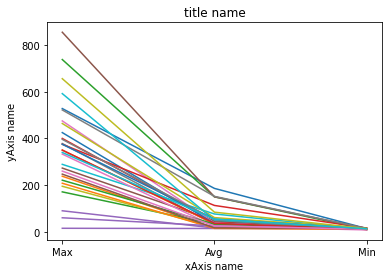

In [195]:
import matplotlib.pyplot as plt

for r in resultsSr:
    plt.plot(["Max","Avg","Min"], r)
  
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()